_authors: Tyler Cochran, Jonathan Waldorf, Jonathan Wurtz, Pedro Lopes_

# Learning objectives:

By the end of this tutorial you will be able to:
* describe the functionality of the QCRank algorithm 
* analyze QCrank's quantum logic implementation determining opportunities for hardware-aware optimization
* state the rules for transpiling the logic of QCrank into neutral-atom native gates
* implement the QCrank algorithm in Cirq using both its natural logic gates and neutral-atom native gates, simulating and validating the circuits
* transpile the circuit into neutral-atom native gates automatically using Cirq tools
* use Bloqade's interoperability wity Cirq to transform transforming ideal circuits to include heuristic noise models for neutral-atom quantum computers
* estimate the performance of the algorithm using those noise models


## Example

Let's apply our learnings from above sections to an explicit example on a realistic and more complex algorithm now. We will focus on QCrank, a protocol for efficiently encoding data on amplitudes of quantum states pointed at by address states. This is an example of what is called a quantum read-only memory (QROM) circuit.


### A brief intro to QCrank

The QCrank circuit takes a collection of $n_d\times 2^{n_a}$ data points organized in $n_d$ vectors as $\vec{x}_j=(x_{0,j},...,x_{2^{n_a}-1,j})$, $j=0,...,n_d-1$. It then efficiently (in depth) encodes that data into quantum states via cyclic permutations of controlled phase rotations from $n_a$ address qubits into $n_d$ data qubits with angles $\vec{\theta_j}=(\theta_{0,j},...,\theta_{2^{n_a}-1,j})$, $j=0,...,n_d-1$,

$$ |\psi(\{\vec{\theta}\})\rangle = \frac{1}{\sqrt{2^{n_a}}} \sum_{i=0}^{2^{n_a}-1} |i\rangle \otimes (\cos\frac{\theta_{i,0}}{2}|0\rangle + \sin \frac{\theta_{i,0}}{2}|1\rangle)...(\cos\frac{\theta_{i,n_d-1}}{2}|0\rangle + \sin \frac{\theta_{i,n_d-1}}{2}|1\rangle) $$

For optimal encoding, the angles $\theta_i$ are determined from a rescaling of the data $\alpha_i=x_i/A$, where $A$ ensures $\alpha_i \in [0,\pi]$, and a [Gray-ordered](https://en.wikipedia.org/wiki/Gray_code) fast Walsh-Hadamard transform

$$ \theta_j = \sum_i W'_{i,j} \alpha_i, \,\,\, \text{for } i,j \in [2^{n_a}] $$

and $W'_{i,j}$ the linear system coefficients of the transform. Notice the $n_d$-long index is not shown here for simplicity.

In sum, QCrank uses $n_a$ address and $n_d$ data qubits to encode $n_d \times 2^{n_a}$ data points. 

> note: we must always turn continuous intro discrete values for $\vec{x}$. If we draw randomly from the $[0,...,K-1]$ set, we must be able to distinguish angles that are $\pi/K$ apart in the presence of noise and limited measurements, if we want to just extract the data (a process not recommended in general, as it would be exponentially hard). Conditions also apply on $n_d$ and $n_a$ for optimal depth, but note that 8 address and 16 data qubits suffice for encoding $2^{12}$ data points with well-separated $\pi/8$ angles with only 24 qubits.

A visual representation of a circuit capable of doing the above follows below, where white boxes correspond to rotations on different angles corresponding to the values of $\theta$


<img src="QCrank_33.png" alt="alt text" width=100%/>

_QCrank's parallel uniformly controlled rotation (pUCR) circuit for 3 address and 3 data qubits. Notice how cyclic permutations of address qubits as controls enable a denser encoding of data. adapted from Balewski et al., Scientific Reports 14, 3435 (2024)_

From a neutral-atom hardware perspective, the **parallel uniformly controlled rotation** (pUCR) structure of this circut, which lets the same address register drive matched patterns of **CX/CZ** across *all* data qubits, is quite desirable as it enables efficient implementation of the algorithm via global gates. From an algorithmic perspective, this also allows the depth of the circuit to grow with $2^{n_a}$ (not with $n_d$).

Let's move to implementation. To get started, let's introduce some helper functions for the fast Walsh-Hadamard transform in Gray-code ordering parts of the algorithm, including the computation of the angles for encoding and optimize scheduling for later needs.

In [1]:
# === Classical helpers (FWHT + Gray + ucr angles) ===
import numpy as np

def fwht_inplace(a: np.ndarray) -> None:
    """In-place Fast Walsh–Hadamard Transform (unnormalized). len(a) must be a power of 2."""
    a = np.asarray(a, dtype=float)
    n = a.shape[0]
    if n & (n - 1):
        raise ValueError("FWHT length must be a power of 2.")
    h = 1
    while h < n:
        for i in range(0, n, 2*h):
            x = a[i:i+h].copy()
            y = a[i+h:i+2*h].copy()
            a[i:i+h]     = x + y
            a[i+h:i+2*h] = x - y
        h *= 2

def gray_code(n_bits: int):
    """Return Gray-code integers 0..2^n_bits-1 in order."""
    return [k ^ (k >> 1) for k in range(1 << n_bits)]

def ucr_angles_from_alphas(alpha_vec: np.ndarray) -> np.ndarray:
    """
    alpha_vec: per-address *angles* (length 2^na) in lexicographic address order.
    Returns: theta coefficients for the UCR ladder, listed in Gray order.
    Implementation: FWHT over alpha (normalize by 2^na) → Gray reindex.
    """
    a = np.array(alpha_vec, dtype=float)
    if a.size & (a.size - 1):
        raise ValueError("alpha_vec length must be a power of 2.")
    t = a.copy()
    fwht_inplace(t)
    t /= a.size
    m = int(np.log2(a.size))
    G = gray_code(m)
    return np.array([t[g] for g in G], dtype=float)


____
### Activity: From Gray code to QCrank scheduling

So as to not leave this classical pre-processing tools hanging alone, let's do an activity. The goal: to connect Gray-code ordering to QCrank’s engine schedule and predict which *address* qubit controls each CNOT.

**Key facts**
- Gray code on $n_a$ bits flips exactly **one** address bit at each step.
- In QCrank’s *engine* schedule, data line $j$ starts at an **offset** $s_j = j mod n_a$.
- At round $t$ (there are $P = 2^{n_a}$ rounds), the CNOT control used for data $j$ is: $ \text{control}(t,j) = (t + s_j) \bmod n_a.$
- We pack CNOTs so **no control repeats in the same moment** (so up to $n_a$ parallel CNOTs per moment).

In what follows you will revise why Gray ordering is important and briefly explore how to predict the control line for each data qubit across QCrank's first few rounds, and evaluate the parallelism of the protocol.

To get started, let's look at the Gray code for addresses and angles. Why Gray? Because multi-control gates are expensive. In Gray order, each consecutive address flips one bit → you can drive a clean “one-control-per-round” schedule. In plain binary order, some steps flip multiple bits → would require multiple controls at once, which is undesirable and not how QCrank is built.

Where FWHT fits: FWHT gives the θ angles we’ll use per round; those angles are indexed in Gray order so they line up with the one-bit-flip schedule. 

Now that we have looked at the role Gray-code plays, we need to generate a schedule of qubit controls and targets at QCrank in a way that allows for high parallelism. The snippet below implements a possibility for us to evaluate:


In [4]:
# === QCrank scheduler preview (self-contained) ===
def engine_controls_qcrank(na: int, nd: int):
    """
    Control rule:
      Let G be Gray order over na bits, and flip(t) the bit that changes
      between G[t] and G[t+1] (cyclic). Define:
         base(t)       = (na - 1) - flip(t)
         control(t, j) = ( base(t) - (j % na) ) % na
      Returns:
        controls: list[P] of rows; controls[t][j] is the address control for target j
        base:     list[P] of base(t) values
        G:        Gray sequence for reference
    """
    P = 1 << na
    G = gray_code(na)
    flips = [((G[t] ^ G[(t + 1) % P]).bit_length() - 1) for t in range(P)]
    base  = [(na - 1) - f for f in flips]
    controls = [[int((base[t] - (j % na)) % na) for j in range(nd)] for t in range(P)]
    return controls, base, G


# ---- Activity parameters (edit here) ----
na = 2
nd = 4
# -----------------------------------------

P = 1 << na
controls, base, G = engine_controls_qcrank(na, nd)

for t in range(P):
    flip_bit = ((G[t] ^ G[(t + 1) % P]).bit_length() - 1)
    print(f"\nRound t={t}  "
          f"(Gray {format(G[t], f'0{na}b')}→{format(G[(t+1)%P], f'0{na}b')}, "
          f"flip bit={flip_bit}, base={base[t]})")
    print("  controls:", [int(c) for c in controls[t]])
    print("  targets : ", list(range(nd)))
    



Round t=0  (Gray 00→01, flip bit=0, base=1)
  controls: [1, 0, 1, 0]
  targets :  [0, 1, 2, 3]

Round t=1  (Gray 01→11, flip bit=1, base=0)
  controls: [0, 1, 0, 1]
  targets :  [0, 1, 2, 3]

Round t=2  (Gray 11→10, flip bit=0, base=1)
  controls: [1, 0, 1, 0]
  targets :  [0, 1, 2, 3]

Round t=3  (Gray 10→00, flip bit=1, base=0)
  controls: [0, 1, 0, 1]
  targets :  [0, 1, 2, 3]


**Questions:**
* Which operations above are parallelizable? What are the sizes of the moments?
* Can you predict the structure for $n_a=4$ and $n_d=8$? What are the sizes of the parallelizable moments? Re-run the code to check!

___

Ok. Nothing quantum so far. The mindset is:

* **FWHT** gives the right $\theta$ so that all those superposed contributions **sum to your target $\alpha$**.
* **Gray order** is just the **playbook for when** to use each $\theta[t]$ so only **one address bit flips per round** (clean hardware schedule).
* In the **crank-like** variant, each data line uses a **cyclically shifted** Gray stream ($s_j=j\bmod n_a$), which is still just a permutation of the same $\theta$.

Now let's use the combined functions above to create a Cirq implementation of the full quantum protocol. We will use a moment-based implementation in order to control parallelism explicitly. Here we go

In [5]:
import cirq
import numpy as np
import math

def build_qcrank(alphas: np.ndarray, na: int, nd: int) -> cirq.Circuit:
    """
    QCrank (angles-in) using the 'engine' entangling schedule.

    Input
    -----
    alphas: flat array of per-address angles,
            length = (2^na) * nd, row-major [address, data].

    Angle flow
    ----------
      theta_gray[j] = FWHT(alpha[:, j]) in Gray order.
      At round t, apply RY(theta_gray[j][t]) on data qubit d_j.

    Entangling schedule (per round t)
    ---------------------------------
      Let G be Gray order over n_a bits and flip(t) the bit that changes
      between G[t] and G[t+1] (cyclic). Define:
          base(t) = (na - 1) - flip(t)
          control(t, j) = ( base(t) - (j % na) ) % na
      Targets are d_0, d_1, ..., d_{nd-1} each round.
      We pack up to `na` disjoint controls per moment for parallelism.

    Returns
    -------
    cirq.Circuit with:
      - H on all address qubits once at the beginning,
      - for each round t:
          * one RY layer on all data qubits,
          * ⌈nd/na⌉ moments of CX(addr[control(t,j)] → data[j]) with disjoint controls.
    """
    # Qubits
    addr = cirq.LineQubit.range(na)
    data = cirq.LineQubit.range(na, na + nd)

    # Angles θ in Gray order per data column
    P = 1 << na
    A = np.asarray(alphas, float).reshape(P, nd)
    theta_gray = [ucr_angles_from_alphas(A[:, j]) for j in range(nd)]

    # Compute base(t) from Gray order
    G = gray_code(na)
    flips = [((G[t] ^ G[(t+1) % P]).bit_length() - 1) for t in range(P)]  # which bit flips
    base  = np.array([(na - 1) - f for f in flips], dtype=int)

    moments: list[cirq.Moment] = []

    # Initial H on address
    moments.append(cirq.Moment(cirq.H.on_each(*addr)))

    # P rounds
    for t in range(P):
        # 1) RY layer (one moment)
        moments.append(cirq.Moment(cirq.ry(theta_gray[j][t]).on(data[j]) for j in range(nd)))

        # 2) Entanglers packed in slices (≤ na ops per moment, distinct controls)
        num_slices = math.ceil(nd / na) if na > 0 else 0
        for b in range(num_slices):
            ops = []
            for k in range(na):
                j = b * na + k
                if j >= nd:
                    break
                ctrl = int((base[t] - (j % na)) % na)
                ops.append(cirq.CNOT(addr[ctrl], data[j]))
            moments.append(cirq.Moment(ops))

    return cirq.Circuit(moments)


Let's take a look at it. Here we go:

In [6]:
na, nd = 2, 4
seed = 2025
rng = np.random.default_rng(seed)

# Angles Θ per address in [0, π]
alphas = rng.uniform(0, np.pi, size=nd * (1 << na))

qc_test = build_qcrank(alphas, na, nd)
print(qc_test, "\n")


                       ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐
0: ───H──────────────────@──────@───────────────────@──────@─────────────────────@──────@───────────────────@──────@─────
                         │      │                   │      │                     │      │                   │      │
1: ───H─────────────────@┼─────@┼───────────────────┼@─────┼@───────────────────@┼─────@┼───────────────────┼@─────┼@────
                        ││     ││                   ││     ││                   ││     ││                   ││     ││
2: ───────Ry(0.703π)────X┼─────┼┼────Ry(0.132π)─────X┼─────┼┼────Ry(-0.123π)────X┼─────┼┼────Ry(0.282π)─────X┼─────┼┼────
                         │     ││                    │     ││                    │     ││                    │     ││
3: ───────Ry(0.225π)─────X─────┼┼────Ry(0.109π)──────X─────┼┼────Ry(0.043π)──────X─────┼┼────Ry(0.005π)──────X─────┼┼────
                               ││       

This is exactly as expected. For a sanity check, compare with figure 1 of QuEra & collaborators IEEE QCE 2025 work!

### Implementation for neutral-atom devices

The natural gates for neutral-atom quantum computers are CZ entanglers and arbitrary single qubit rotations. This transpilation is quite simple for the QCrank circuit. We transform CNOTs in to CZs with the well-known identity $CNOT = H CZ H$. Hadamards commute across the circuit flipping all y-rotation angles. We are left with a global Hadamard layer in the beginning, CZs across the circuit, flipped rotation angles, and a layer of Hadamards in the end only on the data qubits. 

So let's fix that explicitly.

In [7]:
import cirq
import numpy as np
import math

def build_qcrank_native(alphas: np.ndarray, na: int, nd: int) -> cirq.Circuit:
    """
    QCrank (angles-in) compiled to a CZ-native form.

    Structure (P = 2**na):
      - Initial:  H on ALL qubits (address + data)
      - For t = 0..P-1:
          1) RY on all data with angles  -theta_gray[j][t]   (since H·RY(θ)·H = RY(-θ))
          2) CZ entangling block with controls:
               control(t, j) = ( base(t) - (j % na) ) % na
               where base(t) = (na - 1) - flip_bit( G[t] → G[t+1] )
             (packed into ceil(nd/na) moments; no control reused within a moment)
      - Final: H on data only
    """
    # Qubits
    addr = cirq.LineQubit.range(na)
    data = cirq.LineQubit.range(na, na + nd)

    # Angles in Gray order per data column (no per-data cyclic shift)
    P = 1 << na
    A = np.asarray(alphas, float).reshape(P, nd)
    theta_gray = [ucr_angles_from_alphas(A[:, j]) for j in range(nd)]

    # Gray-based control schedule
    G = gray_code(na)
    flips = [((G[t] ^ G[(t + 1) % P]).bit_length() - 1) for t in range(P)]
    base  = np.array([(na - 1) - f for f in flips], dtype=int)

    moments = []

    # Initial global H (address + data)
    moments.append(cirq.Moment([*cirq.H.on_each(*addr), *cirq.H.on_each(*data)]))

    # P rounds: RY(-θ) then CZ entanglers packed in slices
    for t in range(P):
        # 1) RY with sign flip from commuting through H
        moments.append(cirq.Moment(cirq.ry(-theta_gray[j][t]).on(data[j]) for j in range(nd)))

        # 2) CZ entangling block, packed: up to 'na' disjoint controls per moment
        num_slices = math.ceil(nd / na) if na > 0 else 0
        for b in range(num_slices):
            ops = []
            for k in range(na):
                j = b * na + k
                if j >= nd:
                    break
                ctrl = int((base[t] - (j % na)) % na)
                ops.append(cirq.CZ(addr[ctrl], data[j]))
            moments.append(cirq.Moment(ops))

    # Final H on data only
    moments.append(cirq.Moment(cirq.H.on_each(*data)))

    return cirq.Circuit(moments)


Again, let's check visually if we get the circuit we expected

In [8]:
na, nd = 2, 4
seed = 2025
rng = np.random.default_rng(seed)

alphas = rng.uniform(0, np.pi, size=nd *  1 << na) 
qc_test_native = build_qcrank_native(alphas, na, nd)

print(qc_test_native, "\n")

                        ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐
0: ───H───────────────────@──────@───────────────────@──────@─────────────────────@──────@───────────────────@──────@─────────
                          │      │                   │      │                     │      │                   │      │
1: ───H──────────────────@┼─────@┼───────────────────┼@─────┼@───────────────────@┼─────@┼───────────────────┼@─────┼@────────
                         ││     ││                   ││     ││                   ││     ││                   ││     ││
2: ───H───Ry(-0.703π)────@┼─────┼┼────Ry(-0.132π)────@┼─────┼┼────Ry(0.123π)─────@┼─────┼┼────Ry(-0.282π)────@┼─────┼┼────H───
                          │     ││                    │     ││                    │     ││                    │     ││
3: ───H───Ry(-0.225π)─────@─────┼┼────Ry(-0.109π)─────@─────┼┼────Ry(-0.043π)─────@─────┼┼────Ry(-0.005π)─────@─────┼┼────H───
                

___
### Activity: finely picking neutral-atom-preferred gates

Technically, rotations purely around the Y axis are favored over Hadamard gates for simplicity of implementation on hardware. We can achieve that transformation using that a Hadamard gate can be written as $H=Z \sqrt{Y}$; absorb Zs on input qubits starting at 0. (identity proof [here](https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22QFT1%22%5D%2C%5B%22inputA1%22%2C%22%2B%3DA1%22%5D%2C%5B1%2C%22%E2%80%A6%22%5D%2C%5B1%2C%22H%22%5D%2C%5B1%2C%22%E2%80%A6%22%5D%2C%5B1%2C%22Z%22%5D%2C%5B1%2C%22Y%5E%C2%BD%22%5D%5D%7D), modulo global phase)

As a consequence, note that we could also transform $CX_{i,j}$ with control qubit $i$ and target qubit $j$, directly as $CX_{i,j}=\sqrt{Y}_j CZ_{i,j} \sqrt{Y}_j^\dagger$. (perhaps a less-known [identity](
https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22QFT2%22%5D%2C%5B%22inputA2%22%2C1%2C%22%2B%3DA2%22%5D%2C%5B1%2C1%2C%22%E2%80%A6%22%2C%22%E2%80%A6%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C1%2C%22%E2%80%A6%22%2C%22%E2%80%A6%22%5D%2C%5B1%2C1%2C1%2C%22Y%5E-%C2%BD%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C%22Z%22%5D%2C%5B1%2C1%2C1%2C%22Y%5E%C2%BD%22%5D%5D%7D) 
, but which follows immediately from the standard transformation with Hadamard gates and the point above)

Convince yourself of the transformations above. Convince yourself that, in fact, we don't need to worry that much about flipping the signs of the y-rotations. They are imaterial and can be switched at will (globally!). Convince yourself that any possibly remaining $Z$ gate can be absorbed in the initial state or measurement.

Complete the code below in order to create this version of the compiled circuit

In [ ]:
import cirq
import numpy as np
import math

def build_qcrank_native_exercise(
    alphas: np.ndarray, na: int, nd: int
) -> cirq.Circuit:
    """
    QCrank (engine schedule), neutral-atom-native *exercise* version:

    Student prompt:
      “Add a global √Y at the very beginning (on address+data),
       and a final √Y† on data qubits only. Use cirq.ry(±np.pi/2).”
    """
    # Qubits
    addr = cirq.LineQubit.range(na)
    data = cirq.LineQubit.range(na, na + nd)

    # Angles θ in Gray order per data column (no per-data cyclic shift)
    P = 1 << na
    A = np.asarray(alphas, float).reshape(P, nd)
    theta_gray = [ucr_angles_from_alphas(A[:, j]) for j in range(nd)]

    # Engine scheduler from Gray flips:
    #   flip(t) = bit that toggles between G[t] and G[t+1] (cyclic)
    #   base(t) = (na - 1) - flip(t)
    #   control(t, j) = ( base(t) - (j % na) ) % na
    G = gray_code(na)
    flips = [((G[t] ^ G[(t + 1) % P]).bit_length() - 1) for t in range(P)]
    base  = np.array([(na - 1) - f for f in flips], dtype=int)

    moments: list[cirq.Moment] = []

    # --- TODO for students: add global √Y on ALL qubits (address + data) ---

    # P rounds: RY(+θ) then CZ entanglers (packed into ≤ na per moment)
    for t in range(P):
        # RY layer (+θ)
        moments.append(cirq.Moment(cirq.ry(theta_gray[j][t]).on(data[j]) for j in range(nd)))

        # CZ entangling block, disjoint controls per moment
        num_slices = math.ceil(nd / na) if na > 0 else 0
        for b in range(num_slices):
            ops = []
            for k in range(na):
                j = b * na + k
                if j >= nd:
                    break
                ctrl = int((base[t] - (j % na)) % na)
                ops.append(cirq.CZ(addr[ctrl], data[j]))
            moments.append(cirq.Moment(ops))

    # --- TODO for students: add final √Y† on data only ---
    

    return cirq.Circuit(moments)


Test your code below!

In [277]:
na, nd = 2, 4
seed = 2025
rng = np.random.default_rng(seed)

alphas = rng.uniform(0, np.pi, size=nd *  1 << na) 
qc = build_qcrank_native_exercise(alphas, na, nd)

print(qc, "\n")

                              ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐
0: ───Ry(0.5π)──────────────────@──────@───────────────────@──────@─────────────────────@──────@───────────────────@──────@─────────────────
                                │      │                   │      │                     │      │                   │      │
1: ───Ry(0.5π)─────────────────@┼─────@┼───────────────────┼@─────┼@───────────────────@┼─────@┼───────────────────┼@─────┼@────────────────
                               ││     ││                   ││     ││                   ││     ││                   ││     ││
2: ───Ry(0.5π)───Ry(0.703π)────@┼─────┼┼────Ry(0.132π)─────@┼─────┼┼────Ry(-0.123π)────@┼─────┼┼────Ry(0.282π)─────@┼─────┼┼────Ry(-0.5π)───
                                │     ││                    │     ││                    │     ││                    │     ││
3: ───Ry(0.5π)───Ry(0.225π)─────@─────┼┼────Ry(0.109π)──────@─────┼┼────Ry(0.

___

Transpiling by hand, done carefully, is always the most certain way of getting the efficiently transformed circuit, with unitary merges as desired. But it is hard to scale. Below, we will look at our tools to transform circuits automatically and annotate them with noise channels according to models of interest. But before that we need to work on validation of the circuit! If we want to check how deviations from the ideal affect the performance of the protocol, we first need to improve our validation processes.

# Validation

To validate our circuit and evaluate the effect of noise on it, a simple practice is to check if the algorithm does what it should at small scales. Once we confirm that our logic does the expected, evaluation of performance can be performed by either comparing noisily-prepared states with the ideal for fidelity, or simply by studying how the circuit functionality degrades with the noise.

The goal of QCrank is to encode data, so a simple validation can be to see if we can recover the data we encoded. In a practical use of a quantum computer, that is not necessarily a great way to use the device. Recovery of the data is tantamount to state tomography, and that would be tremendously expensive at scale. Rather, data encoded in a state via QCrank would be post-processed by a quantum algorithm that should concentrate probability distributions around few states close to the answer of a given problem. 

But without further digression, let's just put together some utils to validate QCrank:

In [13]:
# === Exact (no-shots) validator using atan2(sqrt(p1), sqrt(p0)) ===
import cirq
import numpy as np

def _exact_addr_data_probs(psi: np.ndarray, na: int, nd: int):
    """Exact p0/p1 per (address a, data j) from the statevector."""
    P = 1 << na
    p1 = np.zeros((P, nd), dtype=float)
    p0 = np.zeros((P, nd), dtype=float)
    probs = np.abs(psi)**2
    addr_mask = (1 << na) - 1
    for idx, prob in enumerate(probs):
        a = idx & addr_mask
        data_bits = (idx >> na) & ((1 << nd) - 1)
        for j in range(nd):
            if (data_bits >> j) & 1:
                p1[a, j] += prob
            else:
                p0[a, j] += prob
    return p0, p1

def _last_controls_engine(na: int, nd: int) -> np.ndarray:
    """
    Engine schedule:
      base(t) = (na-1) - flip_bit(Gray[t]→Gray[t+1]), cyclic.
      The last entangler on d_j (at t=P-1) uses control a_{ (base[-1] - (j % na)) mod na }.
    Returns ctrl_last[j] in [0..na-1].
    """
    P = 1 << na
    G = [k ^ (k >> 1) for k in range(P)]
    flips = [((G[t] ^ G[(t+1) % P]).bit_length() - 1) for t in range(P)]
    base_last = (na - 1) - flips[-1]
    return np.array([ (base_last - (j % na)) % na for j in range(nd) ], dtype=int)

def qcrank_validate_exact(
    alphas_angles: np.ndarray, na: int, nd: int, undo_last_cnot: bool = True
):
    """
    Exact validation of QCrank angles using atan2 decoder.
    Returns: encoded_angles, recovered_angles, rmse, circuit
    """
    P = 1 << na
    TH = np.asarray(alphas_angles, float).reshape(P, nd)

    circ = build_qcrank(alphas_angles, na, nd)  # your CX builder
    psi = cirq.Simulator().simulate(circ).final_state_vector

    p0, p1 = _exact_addr_data_probs(psi, na, nd)

    if undo_last_cnot:
        ctrl_last = _last_controls_engine(na, nd)  # which address bit controls the final CNOT on each d_j
        # swap (p0,p1) when that control bit is 1 for address a
        for a in range(P):
            for j in range(nd):
                if (a >> ctrl_last[j]) & 1:
                    p0[a, j], p1[a, j] = p1[a, j], p0[a, j]

    TH_hat = 2.0 * np.arctan2(np.sqrt(p1), np.sqrt(p0))
    rmse   = float(np.sqrt(np.mean((TH_hat - TH) ** 2)))

    return TH.reshape(-1).tolist(), TH_hat.reshape(-1).tolist(), rmse, circ


Now we test

In [14]:
# Demo: exact recovery should be ~ machine precision after the normalization fix
na, nd, seed = 2, 4, 2025
rng = np.random.default_rng(seed)
alphas_angles = rng.uniform(0.0, np.pi, size=nd * (1 << na))

enc, rec, e, circ = qcrank_validate_exact(alphas_angles, na, nd)
print("Exact RMSE(α̂, α) =", e)
print("encoded  (first 8): ", [f"{x: .3f}" for x in enc[:8]])
print("recovered(first 8): ", [f"{x: .3f}" for x in rec[:8]])


Exact RMSE(α̂, α) = 1.3708577681336598
encoded  (first 8):  [' 3.124', ' 1.200', ' 2.599', ' 2.630', ' 3.066', ' 0.243', ' 0.997', ' 2.889']
recovered(first 8):  [' 0.893', ' 2.981', ' 2.843', ' 0.261', ' 2.647', ' 2.237', ' 2.440', ' 2.217']


Looks like, to within quantum statistical errors, our QCrank state does what it is supposed to do!
___
### Activity: RMSE prediction and further validation

Can you estimate the RMSE per angle in terms of $n_a$, $n_d$ and the number of shots? Also, feel free to informatly test the performance of our neutral-atom-native QCrank constructions.
___

# Automatic transpilations: neutral-atom native gates and noisy circuits

Now let's get to the fun part and start considering QCrank in the context of neutral-atom quantum hardware. Let's begin by importing our noise models and circuit transform tools of interest from our Bloqade-Cirq interoperability tools.

In [215]:
from bloqade.cirq_utils.noise import GeminiOneZoneNoiseModel, transform_circuit
from bloqade.cirq_utils import  transpile

Now let's generate a version of the circuit which we will use throughout to analyze. We will our QCrank test circuits from above. For example

In [213]:
print('Our QCrank test')
print(qc_test)

Our QCrank test
                        ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐                 ┌──┐   ┌──┐
0: ───H──────────────────@──────@─────────────────────@──────@───────────────────@──────@─────────────────────@──────@────
                         │      │                     │      │                   │      │                     │      │
1: ───H──────────────────┼@─────┼@───────────────────@┼─────@┼───────────────────┼@─────┼@───────────────────@┼─────@┼────
                         ││     ││                   ││     ││                   ││     ││                   ││     ││
2: ───────Ry(0.703π)─────X┼─────┼┼────Ry(0.132π)─────X┼─────┼┼────Ry(-0.123π)────X┼─────┼┼────Ry(0.282π)─────X┼─────┼┼────
                          │     ││                    │     ││                    │     ││                    │     ││
3: ───────Ry(0.109π)──────X─────┼┼────Ry(0.043π)──────X─────┼┼────Ry(0.005π)──────X─────┼┼────Ry(0.225π)──────X─────┼┼────
               

Can be transpiled automatically to the neutral-atom gate-set via

In [214]:
transp_qc_test = transpile(qc_test)
print(transp_qc_test)

                                 ┌──┐                                    ┌──┐                             ┌──┐                                      ┌──┐                             ┌──┐                                      ┌──┐                                     ┌──┐                            ┌──┐
0: ───PhXZ(a=0.5,x=-0.5,z=0)──────@─────PhXZ(a=0,x=0,z=1)─────────────────@─────────────────────────────────@─────────────────────────────────────────@───────────────────────────────@─────PhXZ(a=0,x=0,z=1)───────────────────@─────PhXZ(a=0,x=0,z=1)──────────────────@───────────────────────────────@─────────────────────────────
                                  │                                       │                                 │                                         │                               │                                         │                                        │                               │
1: ───PhXZ(a=0.5,x=-0.5,z=0)──────┼@────PhXZ(a=0,x=0,z=1)───────────────

Phased-XZ gates in Cirq are just one convenient way of representing general single qubit rotations. Squinting our eyes and fixing axes and angles properly, we might start identifying the gates we were used to in the discussion so far (the easiest of them being $a=0, x=0, z=1$ corresponding to a $Z$ operator). Setting the axis at $a=0.5$ also suggests rotations around Y, as expected of our native gate set (see exercise above).

It is clear, however, that we are missing several of the circuit optimization opportunities we envisioned when doing our manual transpilation. Notice that applying the `transpile` method even to our manually pre-transpiled circuit from before results on the same outcome here (you may test it!)

Now let's start looking at the noise models. Our goal is to evaluate QCrank's performance under different pre-implemented Bloqade noise models and contrast it with the results from QuEra and friends IEEE QCE 2025 paper (developed using a different bespoke noise model).

To keep it simple and remain comparable with the article mentioned above, we will focus one baseline 1-zone model.

In [ ]:
oneZ_model = GeminiOneZoneNoiseModel()
oneZ_noisy_QCrank = transform_circuit(qc_test,to_native_gateset=True, model = oneZ_model)

print(oneZ_noisy_QCrank)

                                                                                               ┌──┐   ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐                                                                                                                                  ┌──┐   ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

While not the easiest to read, one can clearly extract information about how QCrank is being compiled in the heuristic 1-zone model we chose. For example, we can make the following identifications for the new insertions `A(...)`:
* first layer => local single-qubit error associated with the first layer of `PhXZ` gates
* second layer => moving errors due to 2-qubit gates. Controls are assumed to be shuttled to sitters (so na = mover; nd = sitter. notice the different errors).
* third layer => 2-qubit errors with correlated channels. Notice how qubits 4 and 5 receive annotations for single qubit errors due to being unpaired but under the influence of laser light during entanglement operations.

Importantly, the compilation of moves in this heuristic model is not optimized. To obtain a reliable estimation of the limits of performance of our circuits and their compilation, a good practice involves simply removing all errors associated with atom moving. That can be achieved by rescaling noise channels as follows:


In [221]:
oneZ_no_move_noise=GeminiOneZoneNoiseModel(mover_px=0,mover_py=0,mover_pz=0,sitter_px=0,sitter_py=0,sitter_pz=0)
oneZ_no_move_noisy_QCrank = transform_circuit(qc_test,to_native_gateset=True, model = oneZ_no_move_noise)

print(oneZ_no_move_noisy_QCrank)

                                                                          ┌──┐   ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐                                                                                        ┌──┐   ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

___
### Exercise: explain what you see! Relate the changes in annotation, for example, of the second layer of noise channels to moves.
___

Let's see how noise can affect the performance of our QCrank circuit. As shown before, let's pick a simulation strategy based on density matrices which, despite not being accessible to hardware, will give us meaningful results with lower classical computing overhead. We will rely on our validator from above to test performance according to the obtained RMSE (which, in the noisy version, will have different pre-factors not as simple to estimate as before!). This will allow us to evaluate QCrank similarly to how it was done in the IEEE QCE 2025 paper.

As usual, we start with some utilities. Notice we will run simulations using density matrices, to relax a bit on our classical simulation resource needs.

In [232]:
import warnings

def _indices_for_addr(a: int, na: int, nd: int):
    """Yield basis indices |a⟩_addr ⊗ |d⟩_data (little-endian) for all data bitstrings d."""
    # Little-endian: qubit 0 = LSB. Our layout is [addr(0..na-1), data(0..nd-1)].
    base = a  # address bits occupy positions 0..na-1
    for d in range(1 << nd):
        idx = base | (d << na)  # put data bits after address bits
        yield idx, d

def rmse_angles_exact(
    alphas_angles: np.ndarray,
    na: int,
    nd: int,
    noise_model=None,          # e.g., GeminiOneZoneNoiseModel(...)
    transform_fn=None          # e.g., transform_circuit
):
    """
    Build QCrank (angles-in), optionally apply a noise transform, simulate with
    cirq.DensityMatrixSimulator, and compute exact angles via ⟨Z⟩ conditioned on address.

    Returns: (rmse_value, encoded_angles_list, recovered_angles_list, circuit_used)
    """
    P  = 1 << na
    TH = np.asarray(alphas_angles, float).reshape(P, nd)  # input angles grid

    # 1) Build ideal circuit (no measurement needed)
    base = build_qcrank(alphas_angles, na, nd)

    # 2) Optional noise transform BEFORE simulation
    circ = base
    if (noise_model is not None) and (transform_fn is not None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            circ = transform_fn(circ, model=noise_model)

    # 3) Simulate density matrix
    sim = cirq.DensityMatrixSimulator()
    rho = sim.simulate(circ).final_density_matrix  # complex (2^(na+nd) x 2^(na+nd))
    diag = np.real(np.diag(rho))                   # probabilities in computational basis

    # 4) For each address a, compute exact EV_j = E[Z_j | address=a] from the diagonal
    EV = np.zeros((P, nd), dtype=float)
    for a in range(P):
        # p(address=a) = sum over all data strings of Pr(a,d)
        p_a = 0.0
        num_j = np.zeros(nd, dtype=float)
        for idx, d in _indices_for_addr(a, na, nd):
            p = diag[idx]
            p_a += p
            # contribution to each Z expectation: (-1)^{d_j}
            for j in range(nd):
                bit = (d >> j) & 1
                num_j[j] += (1.0 if bit == 0 else -1.0) * p
        if p_a > 0:
            EV[a, :] = num_j / p_a
        else:
            EV[a, :] = 0.0  # pathological; shouldn't happen in our circuits

    # 5) Convert to angles and compute RMSE
    TH_hat = np.arccos(np.clip(EV, -1.0, 1.0))
    rmse = float(np.sqrt(np.mean((TH_hat - TH) ** 2)))

    return rmse, TH.reshape(-1).tolist(), TH_hat.reshape(-1).tolist(), circ


Let's run simulations for a few different system sizes.

> notice that simulations get very slow above 8 noisy qubits! So mind system sizes to test, and shot sampling as well.

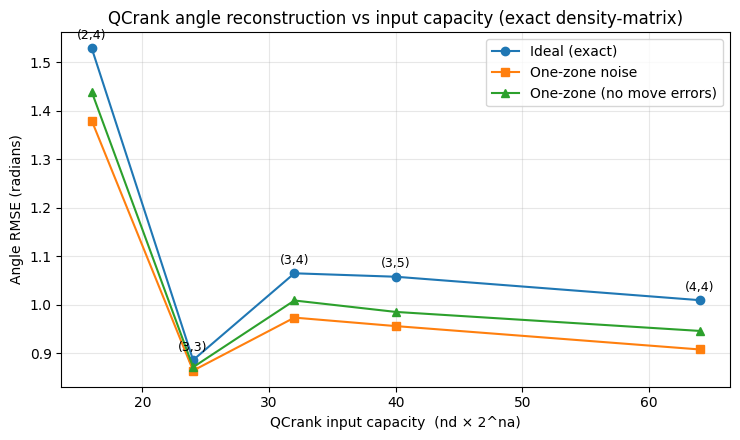

In [231]:
# === Plot: RMSE (angles) vs QCrank input capacity (nd * 2^na), labeled by (na, nd) ===
import numpy as np
import matplotlib.pyplot as plt

# Noise models (assumed defined earlier):
# oneZ_model = GeminiOneZoneNoiseModel()
# oneZ_no_move_noise = GeminiOneZoneNoiseModel(mover_px=0, mover_py=0, mover_pz=0,
#                                              sitter_px=0, sitter_py=0, sitter_pz=0)

configs = [
    (2, 4),  # capacity = 4 * 4 = 16
    (3, 3),  # 3 * 8  = 24
    (3, 4),  # 4 * 8  = 32
    (3, 5),  # 5 * 8  = 40
    (4, 4),  # 4 * 16 = 64
]

seed = 2025
rng  = np.random.default_rng(seed)

capacities, labels = [], []
rmse_ideal, rmse_1Z, rmse_1Z_nomove = [], [], []

for (na, nd) in configs:
    P = 1 << na
    alphas = rng.uniform(0.0, np.pi, size=nd * P)  # input angles in [0, π]

    # Ideal (exact)
    e_ideal, _, _, _ = rmse_angles_exact(alphas, na, nd)

    # One-zone (exact)
    e_1Z, _, _, _ = rmse_angles_exact(alphas, na, nd,
                                      noise_model=oneZ_model,
                                      transform_fn=transform_circuit)

    # One-zone (no move errors) (exact)
    e_nomove, _, _, _ = rmse_angles_exact(alphas, na, nd,
                                          noise_model=oneZ_no_move_noise,
                                          transform_fn=transform_circuit)

    capacities.append(nd * P)         # = nd * 2^na
    labels.append(f"({na},{nd})")
    rmse_ideal.append(e_ideal)
    rmse_1Z.append(e_1Z)
    rmse_1Z_nomove.append(e_nomove)

# Sort by capacity so lines trend left→right
idx = np.argsort(capacities)
x = np.array(capacities, dtype=int)[idx]
y0 = np.array(rmse_ideal)[idx]
y1 = np.array(rmse_1Z)[idx]
y2 = np.array(rmse_1Z_nomove)[idx]
labs = [labels[i] for i in idx]

plt.figure(figsize=(7.5, 4.5))
plt.plot(x, y0, marker='o', label='Ideal (exact)')
plt.plot(x, y1, marker='s', label='One-zone noise')
plt.plot(x, y2, marker='^', label='One-zone (no move errors)')

# Annotate each point with (na, nd) above the max of the three curves at that x
all_y = np.vstack([y0, y1, y2])
ymax = all_y.max(axis=0)
y_pad = 0.02 * (all_y.max() - all_y.min() + 1e-12)
for xi, lab, yi in zip(x, labs, ymax):
    plt.text(xi, yi + y_pad, lab, ha='center', va='bottom', fontsize=9)

plt.xlabel('QCrank input capacity  (nd × 2^na)')
plt.ylabel('Angle RMSE (radians)')
plt.title('QCrank angle reconstruction vs input capacity (exact density-matrix)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


___
### Activity: the effect of geometry

As we see above, an interesting behavior is popping up here. The $(n_a,n_d)=(3,3)$ circuit seems to have much lower RMSE than all others
___

In [235]:
# === Shot-based RMSE for QCrank (angles convention), optional noise ===
import cirq
import numpy as np
import warnings

def _measure_data_then_addr(circ: cirq.Circuit, na: int, nd: int, key: str = "m") -> cirq.Circuit:
    addr = cirq.LineQubit.range(na)
    data = cirq.LineQubit.range(na, na + nd)
    out = cirq.Circuit(circ)
    out.append(cirq.measure(*data, *addr, key=key))  # [d0..d_{nd-1}, a0..a_{na-1}]
    return out

def _addr_ints(samples: np.ndarray, na: int, nd: int) -> np.ndarray:
    addr_bits = samples[:, nd:nd+na].astype(np.int64)
    weights = (1 << np.arange(na, dtype=np.int64))  # LSB=a0
    return addr_bits @ weights

def rmse_angles_from_shots(
    alphas_angles: np.ndarray,
    na: int,
    nd: int,
    shots_total: int | None = None,         # if None, uses shots_per_addr * 2^na
    shots_per_addr: int = 10000,
    seed: int | None = 123,
    noise_model=None,                       # e.g., GeminiOneZoneNoiseModel(...)
    transform_fn=None,                      # e.g., transform_circuit
    key: str = "m",
):
    """
    Build QCrank (angles-in), optionally apply a noise transform,
    sample with a density-matrix sampler (handles noise), reconstruct angles via arccos(<Z>),
    and return RMSE(recovered_angles, input_angles).

    Returns: (rmse_value, encoded_angles_list, recovered_angles_list, circ_with_measure)
    """
    P  = 1 << na
    TH = np.asarray(alphas_angles, float).reshape(P, nd)  # input angles grid

    # Build ideal circuit
    base = build_qcrank(alphas_angles, na, nd)

    # Optional noise transform before measurement
    circ = base
    if (noise_model is not None) and (transform_fn is not None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            circ = transform_fn(circ, model=noise_model)

    # Add measurement [data..., address...]
    circ_m = _measure_data_then_addr(circ, na, nd, key=key)

    # Decide shots
    if shots_total is None:
        shots_total = shots_per_addr * P

    # Sample with density-matrix simulator (works for noisy channels)
    sampler = cirq.DensityMatrixSimulator(seed=seed)
    S = sampler.run(circ_m, repetitions=shots_total).measurements[key]  # (shots_total, nd+na)

    # Reconstruct EV per (address, data)
    addr_idx  = _addr_ints(S, na, nd)
    data_bits = S[:, :nd].astype(np.int64)

    EV = np.zeros((P, nd), dtype=float)
    for a in range(P):
        m = (addr_idx == a)
        if not m.any():  # safeguard
            continue
        p1 = data_bits[m].mean(axis=0)          # Pr(1 | address=a)
        EV[a, :] = 1.0 - 2.0 * p1               # <Z>

    TH_hat = np.arccos(np.clip(EV, -1.0, 1.0))  # recovered angles
    rmse = float(np.sqrt(np.mean((TH_hat - TH) ** 2)))

    return rmse, TH.reshape(-1).tolist(), TH_hat.reshape(-1).tolist(), circ_m


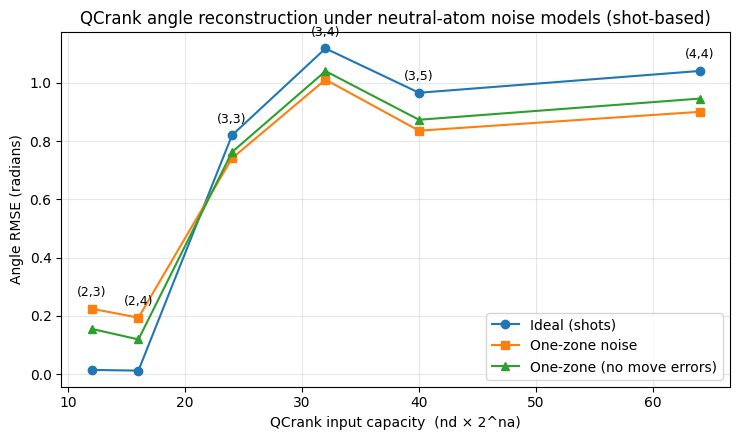

In [239]:
# === Sweep configs and plot RMSE vs QCrank input capacity (shot-based) ===
import numpy as np
import matplotlib.pyplot as plt

# Define noise models you want to compare
oneZ_model = GeminiOneZoneNoiseModel()
oneZ_no_move_noise = GeminiOneZoneNoiseModel(
    mover_px=0, mover_py=0, mover_pz=0,
    sitter_px=0, sitter_py=0, sitter_pz=0
)

# Choose smaller totals (fast) — adjust as needed
configs = [
    (2, 3),  # capacity 3*4 = 12
    (2, 4),  # 16
    (3, 3),  # 24
    (3, 4),  # 32
    (3, 5),  # 40
    (4, 4),  # 64
]

seed = 2025
rng  = np.random.default_rng(seed)

capacities, labels = [], []
rmse_ideal, rmse_1Z, rmse_1Z_nomove = [], [], []

for (na, nd) in configs:
    P = 1 << na
    alphas = rng.uniform(0.0, np.pi, size=nd * P)  # input angles in [0, π]

    # Keep a roughly constant number of shots per address for fair comparison
    shots_per_addr = 8000
    shots_total    = shots_per_addr * P

    # Ideal (shot-based)
    e_ideal, _, _, _ = rmse_angles_from_shots(
        alphas, na, nd,
        shots_total=shots_total, seed=seed
    )

    # One-zone noise (shot-based)
    e_1Z, _, _, _ = rmse_angles_from_shots(
        alphas, na, nd,
        shots_total=shots_total, seed=seed,
        noise_model=oneZ_model, transform_fn=transform_circuit
    )

    # One-zone (no move errors)
    e_nomove, _, _, _ = rmse_angles_from_shots(
        alphas, na, nd,
        shots_total=shots_total, seed=seed,
        noise_model=oneZ_no_move_noise, transform_fn=transform_circuit
    )

    capacities.append(nd * P)
    labels.append(f"({na},{nd})")
    rmse_ideal.append(e_ideal)
    rmse_1Z.append(e_1Z)
    rmse_1Z_nomove.append(e_nomove)

# Sort by capacity and plot
idx = np.argsort(capacities)
x  = np.array(capacities, dtype=int)[idx]
y0 = np.array(rmse_ideal)[idx]
y1 = np.array(rmse_1Z)[idx]
y2 = np.array(rmse_1Z_nomove)[idx]
labs = [labels[i] for i in idx]

plt.figure(figsize=(7.5, 4.5))
plt.plot(x, y0, marker='o', label='Ideal (shots)')
plt.plot(x, y1, marker='s', label='One-zone noise')
plt.plot(x, y2, marker='^', label='One-zone (no move errors)')

# Annotate each point with (na, nd)
ymax = np.vstack([y0, y1, y2]).max(axis=0)
y_pad = 0.03 * (ymax.max() - min(y0.min(), y1.min(), y2.min()) + 1e-12)
for xi, lab, yi in zip(x, labs, ymax):
    plt.text(xi, yi + y_pad, lab, ha='center', va='bottom', fontsize=9)

plt.xlabel('QCrank input capacity  (nd × 2^na)')
plt.ylabel('Angle RMSE (radians)')
plt.title('QCrank angle reconstruction under neutral-atom noise models (shot-based)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


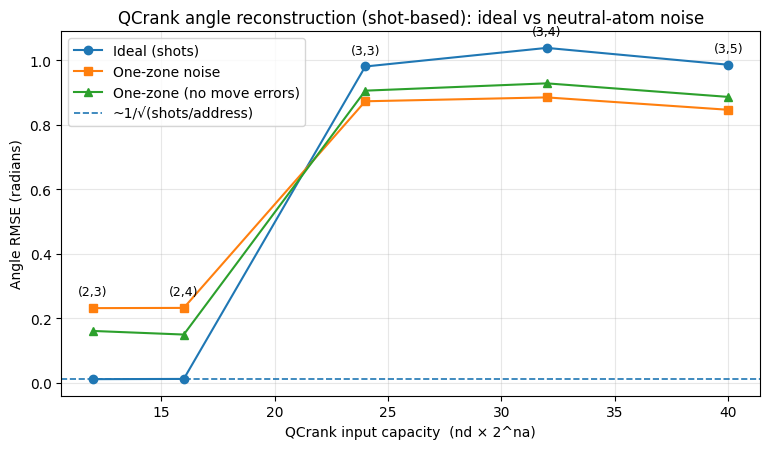

In [240]:
# === Plot RMSE vs input capacity with fair apples-to-apples comparison ===
import numpy as np
import matplotlib.pyplot as plt

# Your configs (smaller totals ok). Group by na so we can reuse the same alpha grid per na.
configs = [(2,3), (2,4), (3,3), (3,4), (3,5)]

shots_per_addr = 8000                         # constant across all tests
seed_alpha     = 2025                         # angles RNG (dataset)
seed_meas      = 777                          # measurement RNG (sampler)
rng_alpha      = np.random.default_rng(seed_alpha)

# Noise models (define earlier in your notebook)
oneZ_model = GeminiOneZoneNoiseModel()
oneZ_no_move_noise = GeminiOneZoneNoiseModel(
    mover_px=0, mover_py=0, mover_pz=0,
    sitter_px=0, sitter_py=0, sitter_pz=0
)

# Build a bank of alpha grids per na; for each na, make enough columns for the max nd used with that na.
from collections import defaultdict
max_nd_by_na = defaultdict(int)
for na, nd in configs:
    max_nd_by_na[na] = max(max_nd_by_na[na], nd)

alpha_bank = {}
for na, nd_max in max_nd_by_na.items():
    P = 1 << na
    alpha_bank[na] = rng_alpha.uniform(0.0, np.pi, size=(P, nd_max))  # same dataset reused for this na

capacities, labels = [], []
rmse_ideal, rmse_1Z, rmse_1Z_nomove = [], [], []

for (na, nd) in configs:
    P = 1 << na
    shots_total = shots_per_addr * P

    # Use the *same* alpha grid for this na; just slice the first nd columns
    A = alpha_bank[na][:, :nd]
    alphas_flat = A.ravel(order='C')

    # Ideal (shot-based)
    e_ideal, _, _, _ = rmse_angles_from_shots(
        alphas_flat, na, nd,
        shots_total=shots_total, seed=seed_meas
    )

    # One-zone noise
    e_1Z, _, _, _ = rmse_angles_from_shots(
        alphas_flat, na, nd,
        shots_total=shots_total, seed=seed_meas,
        noise_model=oneZ_model, transform_fn=transform_circuit
    )

    # One-zone (no move errors)
    e_nomove, _, _, _ = rmse_angles_from_shots(
        alphas_flat, na, nd,
        shots_total=shots_total, seed=seed_meas,
        noise_model=oneZ_no_move_noise, transform_fn=transform_circuit
    )

    capacities.append(nd * P)         # QCrank input capacity
    labels.append(f"({na},{nd})")
    rmse_ideal.append(e_ideal)
    rmse_1Z.append(e_1Z)
    rmse_1Z_nomove.append(e_nomove)

# Sort by capacity
idx = np.argsort(capacities)
x  = np.array(capacities, dtype=int)[idx]
y0 = np.array(rmse_ideal)[idx]
y1 = np.array(rmse_1Z)[idx]
y2 = np.array(rmse_1Z_nomove)[idx]
labs = [labels[i] for i in idx]

plt.figure(figsize=(7.8, 4.6))
plt.plot(x, y0, marker='o', label='Ideal (shots)')
plt.plot(x, y1, marker='s', label='One-zone noise')
plt.plot(x, y2, marker='^', label='One-zone (no move errors)')

# Theory baseline: RMSE ≈ 1/sqrt(shots_per_addr)
plt.axhline(1.0/np.sqrt(shots_per_addr), linestyle='--', linewidth=1.2, label='~1/√(shots/address)')

# Annotate each point with (na, nd)
ymax = np.vstack([y0, y1, y2]).max(axis=0)
y_pad = 0.03 * (ymax.max() - min(y0.min(), y1.min(), y2.min()) + 1e-12)
for xi, lab, yi in zip(x, labs, ymax):
    plt.text(xi, yi + y_pad, lab, ha='center', va='bottom', fontsize=9)

plt.xlabel('QCrank input capacity  (nd × 2^na)')
plt.ylabel('Angle RMSE (radians)')
plt.title('QCrank angle reconstruction (shot-based): ideal vs neutral-atom noise')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
